In [1]:
# 필요한 라이브러리 호출

# >pip install pillow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
torch.cuda.empty_cache()

In [30]:
# 설명 가능한 네트워크 생성

# 13개의 합성곱층과 2개의 완전연결층으로 구성된 네트워크 생성
# 합성곱층과 완결연정층은 렐루(ReLU)라는 활성화 함수 사용

class XAI(torch.nn.Module):
    """
    13번의 Conv2d() 사용
    2번의 Linear() 사용 
    """
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            # bias=False: 선형 변환에서 편향을 사용하지 않겠음
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 0.3만큼 무작위로 일부 뉴련을 비활성화하여 과적합을 방지함
            nn.Dropout(0.3),
            # padding: 입력 이미지 주변에 n픽셀 두께의 패딩을 추가하겠다, 출력 크기 조정
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 커널의 크기는 2이고, 풀링 연산 시 윈도우를 2칸씩 이동하겠다.
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # 네트워크의 특징 추출 부분 이후 클래스 점수를 계산하는 역할, 입력 이미지를 클래스로 분류할 수 있다.
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        # log_softmax()는 신경망 말단의 결괏값을 확률 개념으로 해석하기 위해 소프트맥스 함수의 결과에 log 값을 취한 연산
        return F.log_softmax(x)

In [31]:
# 모델 객체화

model = XAI()
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [32]:
# 특성 맵을 확인하기 위한 클래스 정의

class LayerActivations:
    features = []

    def __init__(self, model, layer_num):
        # 파이토치는 hook 기능을 사용하여 각 계층의 활성화 함수 및 기울기 값을 확인할 수 있음
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # 순전파 과정에서 계산된 텐서, 전파하지 않는 텐서로 만듦, 특성맵이 저장됨
        self.features = output.detach().numpy()

    # hook 삭제
    def remove(self):
        self.hook.remove()

`register_forward_hook`의 목적은 순전파 중 각 네트워크의 모듈의 입력 및 출력을 가져오는 것  

``` python
import torch

x = torch.Tensor([0, 1, 2, 3]).requires_grad_()
y = torch.Tensor([4, 5, 6, 7]).requires_grad_()
w = torch.Tensor([1, 2, 3, 4]).requires_grad_()
z = x + y
# w와 z의 행렬곱, w와 z의 내적을 계산하여 결과르 반환
o = w.matmul(z)
# 역전파를 수행, 네트워크의 모든 매개변수에 대한 기울기가 계산되고 업데이트
# x, y, w 모두 수행
o.backward()
print(x.grad, y.grad, z.grad, w.grad, o.grad)

# o와 z은 특정한 값으로 정해진 것이 아닌 중간 변수이기 때문에 기울기 값을 저장하지 않는다.
> tensor([2., 3., 4., 5.]) tensor([2., 3., 4., 5.]) None tensor([4., 6., 8., 10.]) None
```

torch.Size([1, 3, 100, 100])


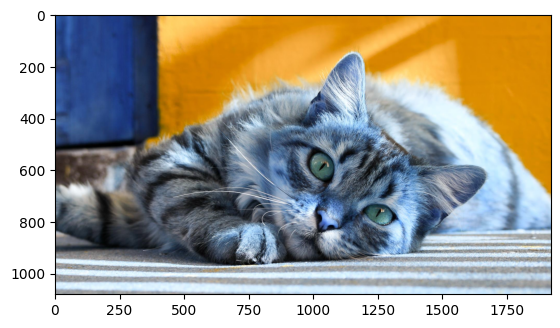

In [33]:
# 이미지 호출

img = cv2.imread('./data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

`cv2.resize`는 이미지 크기를 변경할 때 사용  
  - 첫 번째 파라미터: 변경할 이미지 파일
  - 두 번째 파라미터: 변경될 이미지 크기를 너비, 높이로 지정
  - interpolation: 보간법

이미지 크기가 변경되면, 변형된 이미지의 픽셀을 추정해서 값을 할당해야 함  
보간법: 이에 이미지상에 존재하는 픽셀 데이터에 대한 근사 함수를 적용해 새로운 픽셀 값을 구하는 것

`unsqueeze(dim)`: 1차원 데이터를 생성하는 함수, dim의 값이 텐서의 차원보다 크면 새로운 차원이 추가됨  


``` python
# unsqueeze의 사용
import torch

x1 = torch.rand(3, 10, 64)
x2 = x1.unsqueeze(dim=0)
# [3, 10, 64] -> [1, 3, 10, 64]
print(x2.shape)
print('-' * 10)
x3 = x1.unsqueeze(dim=1)
# [3, 10, 64] -> [3, 1, 10, 64]
print(x3.shape)

"""
torch.Size([1, 3, 10, 64])
torch.Size([3, 1, 10, 64])
"""
```

In [41]:
# Conv2d 특성 맵 확인

# 0번째 Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

C:\Users\leegyuseok\AppData\Local\Temp\ipykernel_13956\3158622621.py:90: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


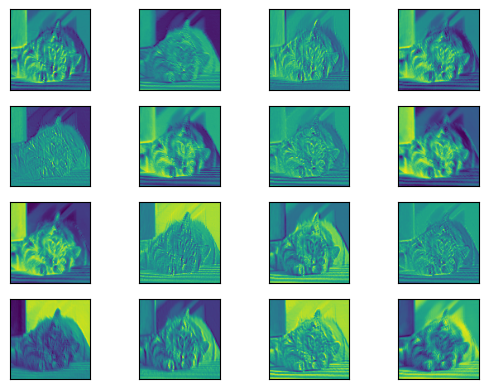

<Figure size 1200x800 with 0 Axes>

In [43]:
# 특성 맵 확인

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        # 눈금 없애기
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        # 첫번째 이미지에 대한 특성맵을 선택하는 것, 16개의 이미지는 모두 하나의 이미지를 소스로 하고 있다.
        # row*10+column: 특성 맵을 1차원으로 펼치기 위한 방법
        axis.imshow(activations[0][row*10+column])
plt.show()

In [44]:
# 20번째 계층에 대한 특성 맵

result = LayerActivations(model.features, 20)
model(img)
activations = result.features

C:\Users\leegyuseok\AppData\Local\Temp\ipykernel_13956\3158622621.py:90: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


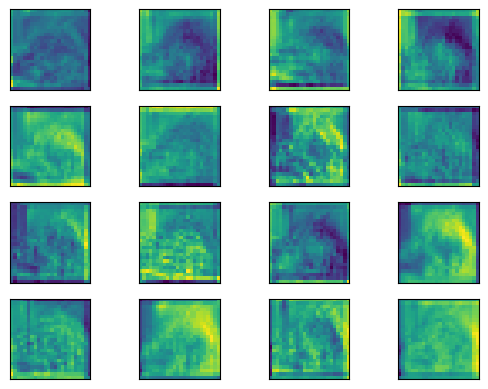

<Figure size 1200x800 with 0 Axes>

In [46]:
# 특성 맵 확인

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        # 눈금 없애기
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        # 첫번째 이미지에 대한 특성맵을 선택하는 것
        # row*10+column: 특성 맵을 1차원으로 펼치기 위한 방법
        axis.imshow(activations[0][row*10+column])
plt.show()

In [47]:
# 40번째 계층에 대한 특성 맵

result = LayerActivations(model.features, 40)
model(img)
activations = result.features

C:\Users\leegyuseok\AppData\Local\Temp\ipykernel_13956\3158622621.py:90: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


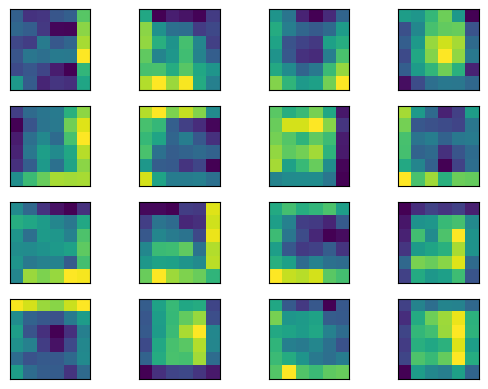

<Figure size 1200x800 with 0 Axes>

In [48]:
# 특성 맵 확인

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        # 눈금 없애기
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        # 첫번째 이미지에 대한 특성맵을 선택하는 것
        # row*10+column: 특성 맵을 1차원으로 펼치기 위한 방법
        axis.imshow(activations[0][row*10+column])
plt.show()


출력층에 가까울수록 원래 형태는 찾아볼 수 없고, 이미지 특징만 전달되는 것을 확인할 수 있다.